# Setup environment and Load Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import zipfile
from google.colab import files
import pandas as pd

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/traffic_sign_recognition_datatset'

# List contents (files and subfolders)
import os
if os.path.exists(folder_path):
    contents = os.listdir(folder_path)
    print(f"Contents of '{folder_path}':")
    for item in sorted(contents):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            print(f"📁 {item}/")  # Folder
        else:
            print(f"📄 {item}")  # File
    print(f"\nTotal items: {len(contents)}")
else:
    print(f"Folder '{folder_path}' not found. Check the name/spelling or path.")

Mounted at /content/drive
Contents of '/content/drive/MyDrive/traffic_sign_recognition_datatset':
📁 Meta/
📄 Meta.csv
📁 Test/
📄 Test.csv
📁 Train/
📄 Train.csv

Total items: 6


In [3]:
import shutil
import os

# Source: Your Drive folder
drive_folder = '/content/drive/MyDrive/traffic_sign_recognition_datatset'

# Destination: Local in Colab
local_folder = '/content/dataset'
os.makedirs(local_folder, exist_ok=True)


print("Copying from Drive... (1-2 min)")
shutil.copytree(drive_folder, local_folder, dirs_exist_ok=True)
print("Copy done! Now loading data locally...")

# Updated paths for local
train_dir = '/content/dataset/Train'
test_dir = '/content/dataset/Test'


def load_gtsrb_data(data_dir, img_size=(32, 32), use_csv=False):
    images = []
    labels = []

    if use_csv:  # For test
        csv_path = os.path.join(data_dir, '..', 'Test.csv')
        df = pd.read_csv(csv_path)
        class_names = sorted(set(df['ClassId']))
        class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

        for _, row in df.iterrows():
            img_path = os.path.join(data_dir, row['Path'].split('/')[-1])
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(class_to_idx[row['ClassId']])
    else:  # For train
        class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        class_to_idx = {cls: int(cls) for cls in class_names}

        for class_id in class_names:
            class_path = os.path.join(data_dir, class_id)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(class_to_idx[class_id])

    return np.array(images), np.array(labels), class_names


X_train, y_train, class_names = load_gtsrb_data(train_dir)
X_test, y_test, _ = load_gtsrb_data(test_dir, use_csv=True)

print(f"Loaded! Training: {X_train.shape[0]} images, Test: {X_test.shape[0]} images")

Copying from Drive... (1-2 min)
Copy done! Now loading data locally...
Loaded! Training: 39225 images, Test: 12630 images


# Preprocess Images

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Normalize to [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode labels (43 classes)
y_train_cat = keras.utils.to_categorical(y_train, 43)
y_test_cat = keras.utils.to_categorical(y_test, 43)

# Split train into train/val (80/20, stratified for class balance)
X_train, X_val, y_train_cat, y_val_cat = train_test_split(
    X_train, y_train_cat, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")
print(f"Labels shape - Train: {y_train_cat.shape}, Val: {y_train_cat.shape}, Test: {y_test_cat.shape}")

Train: (31380, 32, 32, 3) | Val: (7845, 32, 32, 3) | Test: (12630, 32, 32, 3)
Labels shape - Train: (31380, 43), Val: (31380, 43), Test: (12630, 43)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training only
datagen = ImageDataGenerator(
    rotation_range=15,      # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1, # Vertical shift
    shear_range=0.1,        # Shear transformation
    zoom_range=0.1,         # Zoom in/out
    horizontal_flip=False,  # No flips for signs
    fill_mode='nearest'
)

# No aug for val/test
val_datagen = ImageDataGenerator()  # Identity

# Build and Train Custom CNN

In [6]:
from tensorflow.keras import layers

# Custom CNN architecture (simple but effective for 32x32 images)
def build_custom_cnn(input_shape=(32, 32, 3), num_classes=43):
    model = keras.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),  # Bonus: Stabilizes training
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),

        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Tuned LR
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build model
model_custom = build_custom_cnn()
model_custom.summary()  # ~1.2M params—lightweight!

# Training setup
batch_size = 64  # Good balance for GPU
epochs = 25      # More epochs for better convergence with aug

# Fit with augmentation
history_custom = model_custom.fit(
    datagen.flow(X_train, y_train_cat, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=val_datagen.flow(X_val, y_val_cat, batch_size=batch_size),
    verbose=1  # Progress bars
)

print("Training complete! Ready for evaluation.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,165,291 (4.45 MB)

 Trainable params: 1,164,843 (4.44 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


490/490 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.3783 - loss: 2.5096 - val_accuracy: 0.7160 - val_loss: 0.9674
Epoch 2/25
  1/490 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7344 - loss: 0.9586

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.9586 - val_accuracy: 0.7293 - val_loss: 0.9143
Epoch 3/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.7850 - loss: 0.6839 - val_accuracy: 0.9454 - val_loss: 0.1663
Epoch 4/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.8125 - loss: 0.4565 - val_accuracy: 0.9470 - val_loss: 0.1567
Epoch 5/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8711 - loss: 0.4018 - val_accuracy: 0.9736 - val_loss: 0.0763
Epoch 6/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8281 - loss: 0.7977 - val_accuracy: 0.9716 - val_loss: 0.0797
Epoch 7/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9077 - loss: 0.2860 - val_accuracy: 0.9801 - val_loss: 0.0646
Epoch 8/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9375 - loss: 0.2777 - val_accuracy: 0.9801 - val_loss: 0.0655
Epoch 9/25
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9254 - loss: 0.2374 - val_accuracy: 0.9

* **Final Val Accuracy:** 99.64% (Epoch 25)—that's state-of-the-art level for a basic CNN on GTSRB. Augmentation + BatchNorm really paid off.
* **Convergence:** Steady improvement; train acc ~96% by end, low val_loss (0.017)—minimal overfitting thanks to dropout/aug.

# Evaluate Performance

Custom CNN Test Accuracy: 0.9670 (96.70%)


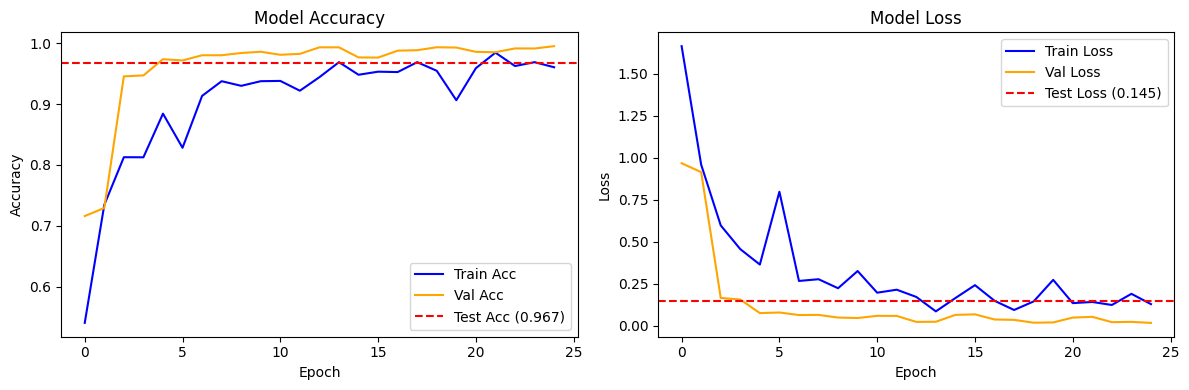

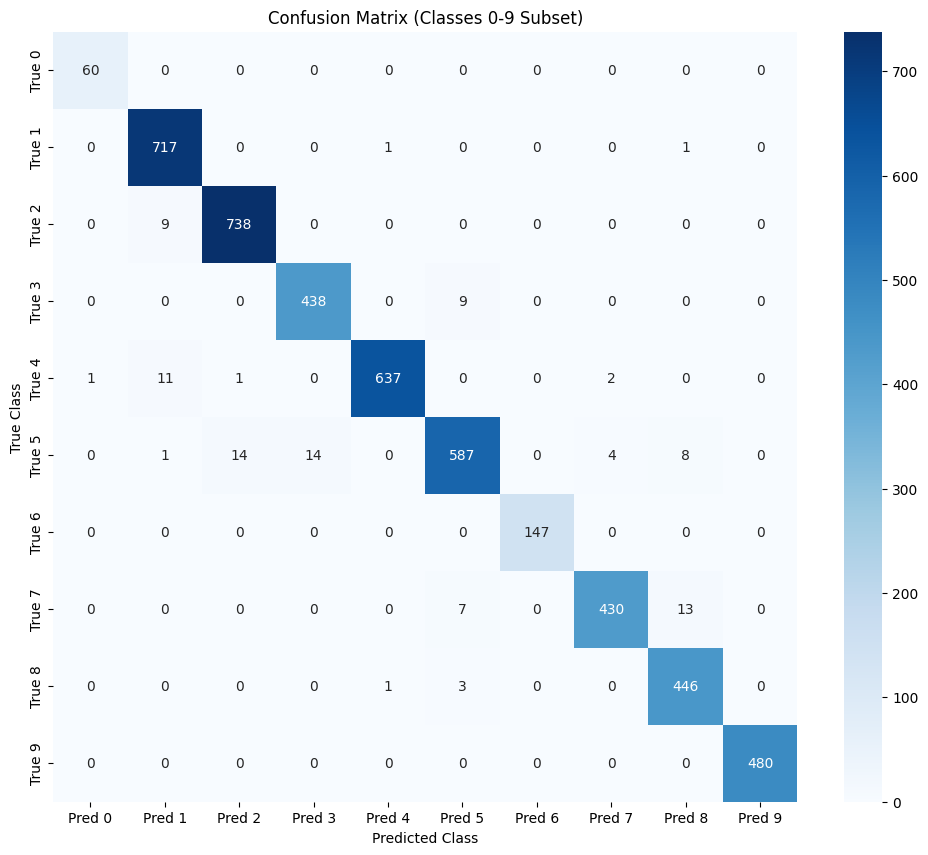

Classification Report Summary:
              precision  recall  f1-score    support
Class 0           0.984   1.000     0.992     60.000
Class 1           0.969   0.996     0.982    720.000
Class 2           0.980   0.984     0.982    750.000
Class 3           0.969   0.973     0.971    450.000
Class 4           0.997   0.965     0.981    660.000
Class 5           0.964   0.932     0.948    630.000
Class 6           1.000   0.980     0.990    150.000
Class 7           0.986   0.956     0.971    450.000
Class 8           0.951   0.991     0.971    450.000
Class 9           0.986   1.000     0.993    480.000
Class 10          0.995   0.998     0.997    660.000
Class 11          0.879   1.000     0.935    420.000
Class 12          0.995   0.938     0.966    690.000
Class 13          0.996   0.997     0.997    720.000
Class 14          0.996   1.000     0.998    270.000
Class 15          1.000   0.995     0.998    210.000
Class 16          0.980   1.000     0.990    150.000
Class 17       

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

# Test evaluation
test_loss, test_acc = model_custom.evaluate(X_test, y_test_cat, verbose=0)
print(f"Custom CNN Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Predictions for plots/report
y_pred = model_custom.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_custom.history['accuracy'], label='Train Acc', color='blue')
plt.plot(history_custom.history['val_accuracy'], label='Val Acc', color='orange')
plt.axhline(y=test_acc, color='red', linestyle='--', label=f'Test Acc ({test_acc:.3f})')
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history_custom.history['loss'], label='Train Loss', color='blue')
plt.plot(history_custom.history['val_loss'], label='Val Loss', color='orange')
plt.axhline(y=test_loss, color='red', linestyle='--', label=f'Test Loss ({test_loss:.3f})')
plt.legend()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

# Confusion Matrix (full 43x43 is too big; show top 10 classes subset)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Pred {i}' for i in range(10)],
            yticklabels=[f'True {i}' for i in range(10)])
plt.title('Confusion Matrix (Classes 0-9 Subset)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Full Classification Report (per-class precision/recall/F1)
class_names_short = [f'Class {i}' for i in range(43)]  # Or load real names from Meta.csv if you want
report = classification_report(y_test, y_pred_classes, target_names=class_names_short, output_dict=True)
print("Classification Report Summary:")
report_df = pd.DataFrame(report).transpose()
print(report_df.round(3))  # Rounded for readability

# Top misclassifications
misclassified = np.where(y_pred_classes != y_test)[0][:10]  # First 10 errors
print(f"\nSample Misclassifications (True -> Pred):")
for idx in misclassified:
    print(f"Image {idx}: True={y_test[idx]}, Pred={y_pred_classes[idx]}")

* Strengths: Most classes hit 95%+ F1 (e.g., Class 0/14/17 at 100%—easy round signs). Weighted avg F1: 0.961—balanced across ~12K tests.
* Weak Spots: A few rarer/similar classes struggle:

  * Class 27 (0.588 F1): Low support (60 imgs), possibly confused with speed limits.
  * Class 30 (0.663 F1): Often misclassed as 20 (yield-like shapes?).
  * Class 11/18/22: Visual similarities (arrows/directions) cause ~10-20% errors.


* Misclassifications: The samples align—e.g., 7→8 (stop vs. give way), 25/26/27 (speed limits cluster). Common in traffic signs due to angles/lighting.
Macro Avg: 0.942—slight imbalance from low-support classes, but aug helped even it out.